In [1]:
import geopandas as gpd
import pandas as pd
import lake_wise_lse_analyze
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns

Initializing pandarallel...
INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


<GeoAxes: >

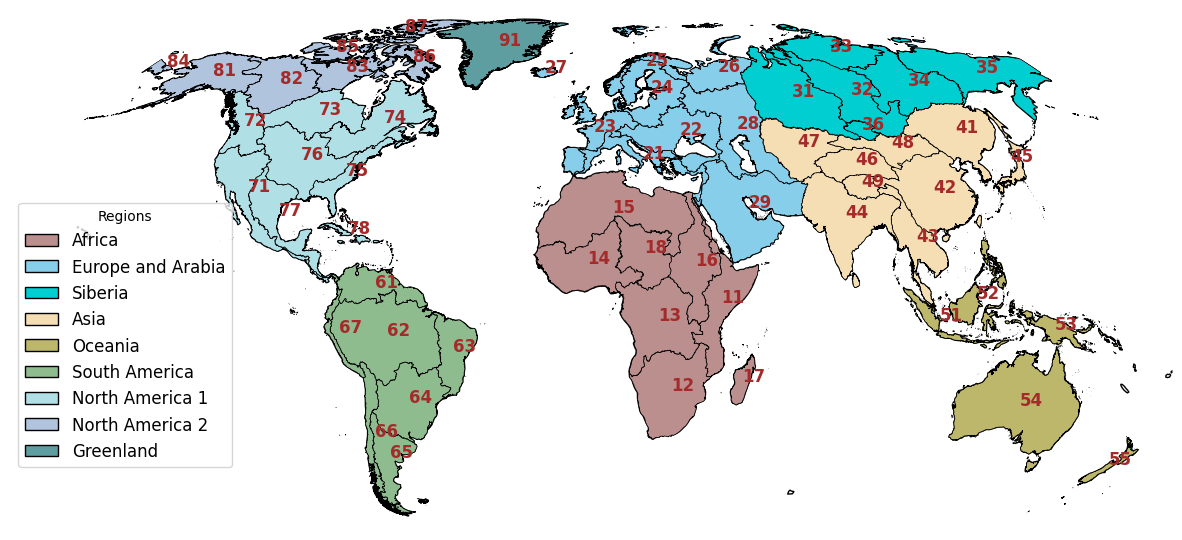

In [2]:

import geopandas as gpd
import pandas as pd
import lake_wise_lse_analyze
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, LineString, GeometryCollection
from shapely.ops import split, unary_union
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely import affinity
import warnings
warnings.filterwarnings("ignore")

basin_id_list = [
    1020000010, 1020011530, 1020018110, 1020021940, 1020027430, 1020034170, 1020035180, 1020040190,
    2020000010, 2020003440, 2020018240, 2020024230, 2020033490, 2020041390, 2020057170, 2020065840, 2020071190,
    3020000010, 3020003790, 3020005240, 3020008670, 3020009320, 3020024310,
    4020000010, 4020006940, 4020015090, 4020024190, 4020034510, 4020050210, 4020050220, 4020050290, 4020050470,
    5020000010, 5020015660, 5020037270, 5020049720, 5020082270, 
    6020000010, 6020006540, 6020008320, 6020014330, 6020017370, 6020021870, 6020029280,
    7020000010, 7020014250, 7020021430, 7020024600, 7020038340, 7020046750, 7020047840, 7020065090,
    8020000010, 8020008900, 8020010700, 8020020760, 8020022890, 8020032840, 8020044560,
    9020000010
]

basin_id_list = [basin_id for basin_id in basin_id_list]

basin_display_name_dict = {}
basin_start_num_count = {i:0 for i in range(1, 10)}
for basin_id in basin_id_list:
    basin_start_num = int(str(basin_id)[0])
    basin_display_name_dict[basin_id] = f'{basin_start_num}{basin_start_num_count[basin_start_num]+1}'
    basin_start_num_count[basin_start_num] += 1

region_color_dict = {
    '1': 'rosybrown',
    '2': 'skyblue',
    '3': 'darkturquoise',
    '4': 'wheat',
    '5': 'darkkhaki',
    '6': 'darkseagreen',
    '7': 'powderblue',
    '8': 'lightsteelblue',
    '9': 'cadetblue'
}

region_name_dict = {
    '1': 'Africa',
    '2': 'Europe and Arabia',
    '3': 'Siberia',
    '4': 'Asia',
    '5': 'Oceania',
    '6': 'South America',
    '7': 'North America 1',
    '8': 'North America 2',
    '9': 'Greenland'
}

basin_colors_dict = {basin_id: region_color_dict[str(basin_id)[0]] for basin_id in basin_id_list}

def split_antimeridian(geometry):
    if geometry.is_empty or geometry.bounds[0] > 180 or geometry.bounds[2] < -180:
        return geometry
    if geometry.bounds[0] < -180:
        geometry = affinity.translate(geometry, xoff=360)
    split_line = LineString([(180, -90), (180, 90)])
    split_geometries = split(geometry, split_line)
    
    result = []
    for geom in split_geometries.geoms if isinstance(split_geometries, GeometryCollection) else [split_geometries]:
        if geom.bounds[0] >= 180:
            geom = affinity.translate(geom, xoff=-360)
        elif geom.bounds[2] < -180:
            geom = affinity.translate(geom, xoff=360)
        result.append(geom)
    
    # Merge the split geometries back together
    merged_geometry = unary_union(result)
    return merged_geometry

def handle_antimeridian(gdf):
    gdf['geometry'] = gdf['geometry'].apply(split_antimeridian)
    return gdf

basin_gdf = gpd.read_file('/WORK/Data/global_lake_area/vector_data/hybas_lev02/hybas_lev02_v1c_merged_lake_count_added_gt100.geojson')[['HYBAS_ID', 'geometry']]
basin_gdf = handle_antimeridian(basin_gdf)
basin_id_column_name = 'HYBAS_ID'

lake_wise_lse_analyze.basin_distribution_plot(
    basin_id_list=basin_id_list,
    basin_display_name_dict=basin_display_name_dict,
    basin_color_dict=basin_colors_dict,
    region_name_dict=region_name_dict,
    region_color_dict=region_color_dict,
    basin_gdf=basin_gdf,
    basin_id_column_name=basin_id_column_name,
    extent=[-180, 180, -60, 90],
    projection=ccrs.Robinson(),
    save_path='basin_distribution.pdf'
)

In [ ]:
import pandas as pd
import numpy as np
import lake_wise_lse_analyze
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

lse_csv_path = '/WORK/Data/global_lake_area/area_csvs/lakes/csv/lakes_all.csv'
lse_df = pd.read_csv(lse_csv_path)
significance_column_names = ['rao_mk_test_on_seasonal_amplitude_trend']
trend_column_names = ['linear_trend_of_standard_deviation_per_period']
lake_size_bins = [0, 1, 10, 100, 1000, 5000, np.inf]
lake_size_labels = ['<1', '1-10', '10-100', '100-1000', '1000-5000', '5000+']
lake_area_column_name = 'mean_area'
fig_filenames = [
    'seasonal_amplitude_trend_number_percentage_20240726.pdf'
]
for significance_column_name, trend_column_name in zip(significance_column_names, trend_column_names):
    lake_wise_lse_analyze.percentage_pie_plot_of_difference_sized_lakes(
        lse_df=lse_df,
        significance_column_name=significance_column_name,
        trend_column_name=trend_column_name,
        lake_size_bins=lake_size_bins,
        lake_size_labels=lake_size_labels,
        lake_area_column_name=lake_area_column_name,
        show_plot=False
    )
    plt.savefig(fig_filenames.pop(0), format='pdf', bbox_inches='tight')
    